In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
import matplotlib.pyplot as plt
import matplotlib.cm as cm

a = 8 # per Horvath et al. in ms
b = 2.2*1000/1800 # own measurements in ms
c = 120/1800 # own measurements in ms

def pastel_color(color):
    """Return a pastel shade of the given color."""
    white = np.array([1, 1, 1,1])
    return white + (color - white) * 0.9

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


Extension of the notebook created by Blanka Horvath, Aitor Muguruza, Mehdi Tomas.
Heston pricing with one forward pass

In [2]:
import numpy as np
import scipy.integrate

r = 0.00
q = 0.00
s = 1.0
def phi(u, tau, kappa, theta, sigma_v, rho, v0):
    alpha_hat = -0.5 * u * (u + 1j)
    beta = kappa - 1j * u * sigma_v * rho
    gamma = 0.5 * sigma_v ** 2
    d = np.sqrt(beta**2 - 4 * alpha_hat * gamma)
    g = (beta - d) / (beta + d)
    h = np.exp(-d*tau)
    A_ = (beta-d)*tau - 2*np.log((g*h-1) / (g-1))
    A = kappa * theta / (sigma_v**2) * A_
    B = (beta - d) / (sigma_v**2) * (1 - h) / (1 - g*h)
    return np.exp(A + B * v0)

def integral(k, tau,kappa, theta, sigma_v, rho, v0):
    integrand = (lambda u: 
        np.real(np.exp((1j*u + 0.5)*k)*phi(u - 0.5j, tau, kappa, theta, sigma_v, rho, v0))/(u**2 + 0.25))

    i, err = scipy.integrate.quad_vec(integrand, 0, np.inf)
    return i

def call(k, tau, kappa, theta, sigma_v, rho, v0):
    a = np.log(s/k) + (r-q)*tau
    i = integral(a, tau, kappa, theta, sigma_v, rho, v0)        
    return s * np.exp(-q*tau) - k * np.exp(-r*tau)/np.pi*i
    
def price(strikes, maturities, kappa, theta, sigma_v, rho, v0):
    prices = np.zeros(( len(maturities),len(strikes)))
    vols = np.zeros(( len(maturities),len(strikes)))
    
    for i, tau in enumerate(maturities):
        for j, k in enumerate(strikes):
            prices[i,j] = call(k, tau, kappa, theta, sigma_v,-rho, v0)
            vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')
    
    return np.nan_to_num(vols)

def price_array(strikes, maturities, arr):
    v = arr[0]
    kappa = arr[4]    
    theta = arr[3]
    sigma_v = arr[2] 
    rho = arr[1]
    return price(strikes, maturities, arr[4], arr[3], arr[2], arr[1], arr[0])

In [3]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:5]
yy=dat[:,5:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1, 0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(12000, 5)


In [4]:
# yy = pd.read_csv('myprices.csv', header=None).values
# yy = yy.reshape(-1, 8,11)
# yy = yy[:, 1:, :]
# yy = yy.reshape(-1, 7*11)


In [5]:
# df = pd.DataFrame(myprices)

# # Save the DataFrame to a CSV file
# df.to_csv('myprices.csv', index=False, header=False)

In [6]:
# myprices = myprices.reshape(-1, 88)
# yy = myprices

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [8]:
x_train_transform.shape

(10200, 88)

In [9]:
y_test_transform.shape

(1800, 5)

In [10]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

    
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)

def xinversetransform(x):
    return scale2.inverse_transform(x)

In [11]:
ub=[0.04,-0.1,1.0,0.2,10.0]
lb=[0.0001,-0.95,0.01,0.01,1]
def myscale(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

In [12]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

In [13]:
import keras
from keras.layers import Activation
from keras import backend as K
# from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(5,))
x1 = keras.layers.Dense(40,activation = 'elu')(input1)
x2=keras.layers.Dense(40,activation = 'elu')(x1) 
x3=keras.layers.Dense(40,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 88)                3608      
                                                                 
Total params: 7128 (55.69 KB)
Trainable params: 7128 (55.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
modelGEN.compile(loss = 'mse', optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
319/319 [==============================] - 1s 2ms/step - loss: 0.1757 - val_loss: 0.0361
Epoch 2/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0267 - val_loss: 0.0213
Epoch 3/200
319/319 [==============================] - 0s 2ms/step - loss: 0.0174 - val_loss: 0.0150
Epoch 4/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0102
Epoch 5/200
319/319 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 6/200
319/319 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 7/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 8/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 10/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0039 - val_lo

1/1 [==============================] - 0s 85ms/step


C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


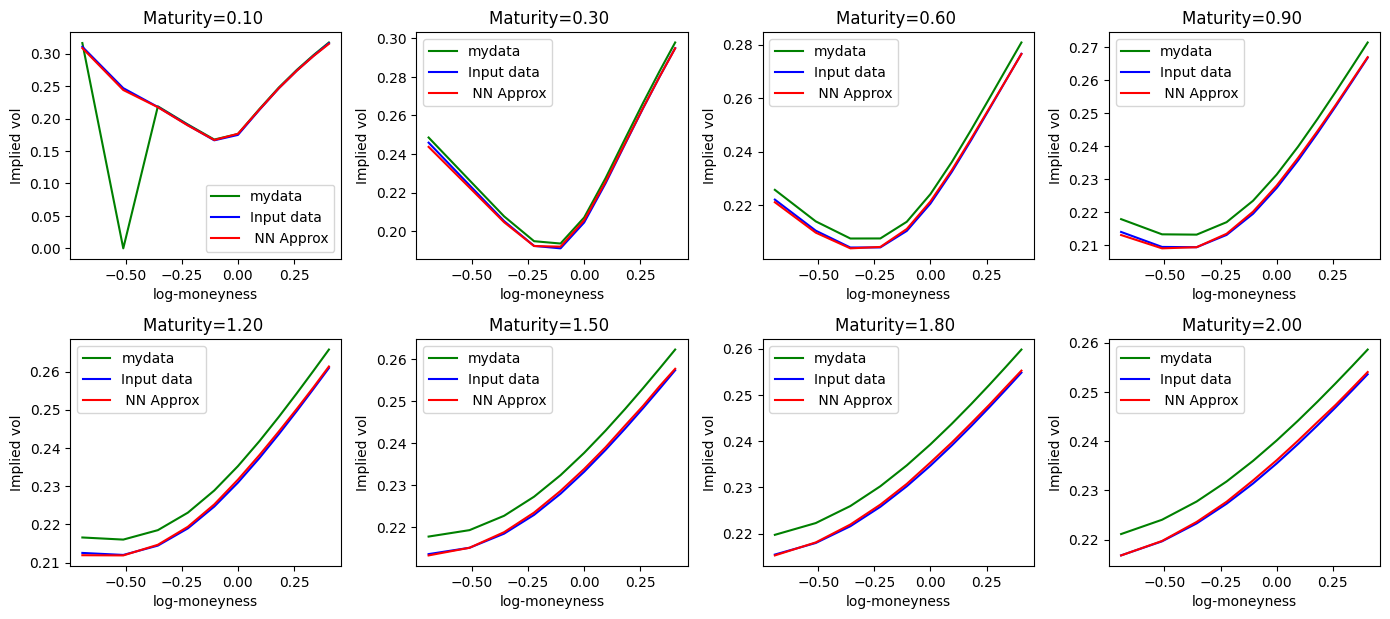

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 1250
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
# print(scale.inverse_transform(y_sample))
maturities_dim = len(maturities)
strikes_dim = len(strikes)

prediction=xinversetransform(modelGEN.predict(y_sample.reshape(1,5))[0].reshape(1, -1)).reshape(-1)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0), price_array(strikes, maturities, y_test[sample_ind])[i],'g',label="mydata")
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

In [16]:

import keras.backend as K
import tensorflow as tf

def CostFuncKeras(x, sample_ind):
    x = tf.convert_to_tensor(x, dtype=tf.float64)
    pred = modelGEN(x)
    target = tf.convert_to_tensor(x_test_transform[sample_ind], dtype=tf.float64)
    cost = tf.reduce_sum(tf.pow(pred - target, 2)) #+ tf.reduce_sum(tf.nn.relu(tf.abs(x )-1)*10000)
    # Converting to NumPy array
    return cost
def CostFuncKerasWrapper(x, sample_ind):
    x = x.reshape(1,-1)
    return CostFuncKeras(x, sample_ind).numpy().reshape(-1)
def JacobianKeras(x, sample_ind):
    x_var = tf.Variable(x, dtype=tf.float64)  # Using TensorFlow Variable
    with tf.GradientTape() as tape:
        tape.watch(x_var)
        cost = CostFuncKeras(x_var, sample_ind)  # Ensure this returns a TF tensor
    grads = tape.gradient(cost, x_var)
    
    # Converting to NumPy array
    return grads
def JacobianKerasWrapper(x, sample_ind):
    x = x.reshape(1,-1)
    return JacobianKeras(x, sample_ind).numpy().reshape(-1)
def CostFuncLSKeras(x, sample_ind):
    x = K.constant(x)
    pred = modelGEN(x)
    target = K.constant(x_test_transform[sample_ind])
    cost = pred - target
    
    # Converting to NumPy array
    return K.get_value(cost)


def JacobianLSKeras(x, sample_ind):
    x_var = K.variable(value=x)
    cost = CostFuncLSKeras(x_var, sample_ind)
    jacobian = [K.gradients(c, x_var)[0] for c in K.unstack(cost, axis=-1)]
    jacobian = K.stack(jacobian)
    
    # Converting to NumPy array
    return K.get_value(jacobian)


In [17]:

bounds=((-1, 1), (-1, 1), (-1, 1),(-1, 1),(-1, 1))

In [18]:
import time
import scipy
Approx=[]
Timing=[]
sample_ind = 500
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
solutions_usefull = []
solutions=np.zeros([4,5])
times=np.zeros(4)
total_error = 0
init=np.zeros(5)
for i in range(1):
    disp=str(i+1)+"/1800"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    # how to make it verbose? 

    I=scipy.optimize.minimize(CostFuncKerasWrapper,x0=init,args=i ,bounds=bounds,method='SLSQP',jac=JacobianKerasWrapper,tol=1E-20,options={"maxiter":5000})
    end= time.time()
    print()
    print(I)
    solutions[0,:]=myinverse(I.x)
    print(I.x)
    print(myinverse(I.x))
    print(y_test[sample_ind])
    total_error += np.mean((price_array(strikes=strikes, maturities=maturities, arr=myinverse(I.x)).reshape(-1)-X_sample)**2)
    solutions_usefull.append(myinverse(I.x))
    times[0]=end-start
    #SLSQP
    # start= time.time()
    # I=scipy.optimize.minimize(CostFuncKerasWrapper,x0=init,args=i,method='SLSQP',jac=JacobianKerasWrapper,tol=1E-10,options={"maxiter":5000})
    # end= time.time()
    # solutions[1,:]=myinverse(I.x)
    # times[1]=end-start
    # #BFGS
    # start= time.time()
    # I=scipy.optimize.minimize(CostFuncKerasWrapper,x0=init,args=i,method='BFGS',jac=JacobianKerasWrapper,tol=1E-10,options={"maxiter":5000})
    # end= time.time()
    # solutions[2,:]=myinverse(I.x)
    # times[2]=end-start
    #Levenberg-Marquardt
    # start= time.time()
    # I=scipy.optimize.least_squares(CostFuncLSKeras,init, JacobianLSKeras,args=(i,),gtol=1E-10)
    # end= time.time()
    # solutions[3,:]=myinverse(I.x)
    # times[3]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

1/1800
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.008064367354917171
       x: [-8.210e-01  1.000e+00  3.533e-01  9.151e-01 -1.018e-02]
     nit: 19
     jac: [-1.630e-08 -3.094e-01 -1.641e-08 -5.211e-08 -3.530e-08]
    nfev: 37
    njev: 19
[-0.82100795  1.          0.35333317  0.91511021 -0.01018412]
[ 3.67089135e-03 -1.00000000e-01  6.79899920e-01  1.91935470e-01
  5.45417147e+00]
[ 0.02646388 -0.35475571  0.96749104  0.12860385  3.90243714]


C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')


In [19]:
total_error

0.007424421264736265

In [20]:
total_error / 1800

4.124678480409036e-06

In [21]:
solutions_usefull[0]

array([ 3.67089135e-03, -1.00000000e-01,  6.79899920e-01,  1.91935470e-01,
        5.45417147e+00])

1/1 [==============================] - 0s 23ms/step


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')


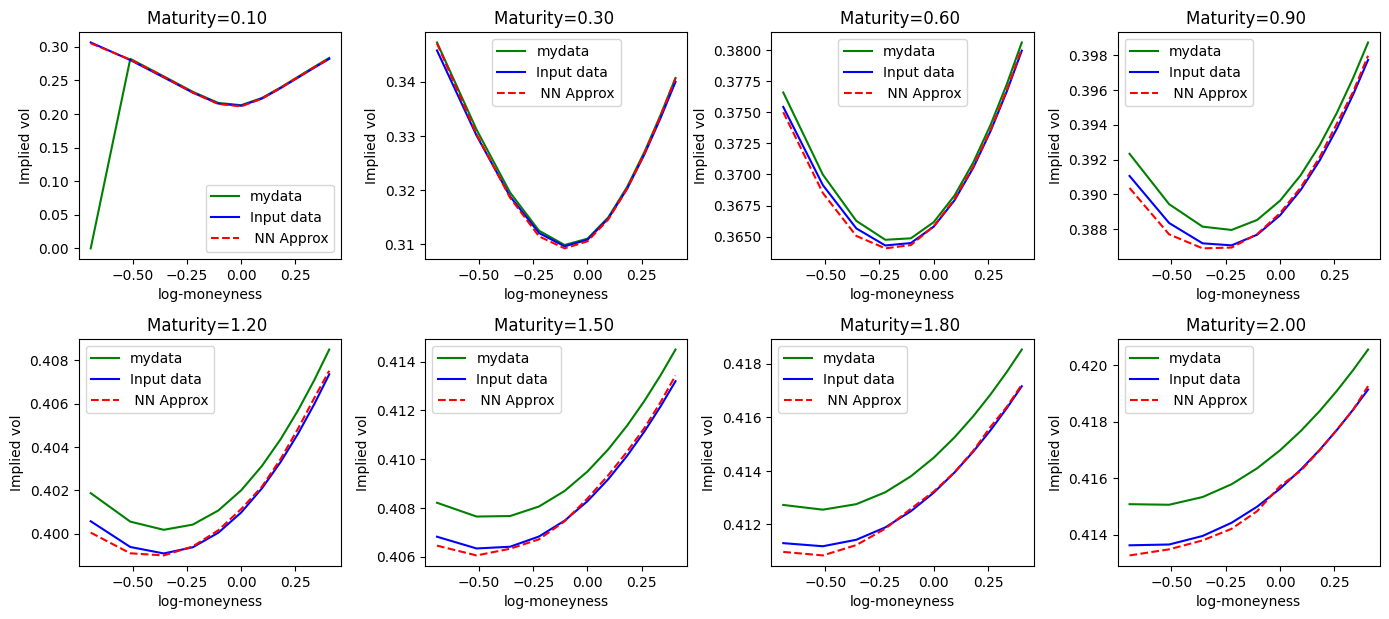

In [22]:
# prediction=xinversetransform(modelGEN.predict(solutions_usefull[0].reshape(1, -1))[0].reshape(1,-1))
sample_ind = 0
transformed = myscale(solutions_usefull[sample_ind])
prediction = xinversetransform(modelGEN.predict(transformed.reshape(1,5))[0].reshape(1, -1)).reshape(-1)
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
y_guess = solutions_usefull[0]
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    plt.plot(np.log(strikes/S0), price_array(strikes, maturities, y_guess).reshape(-1)[i*strikes_dim:(i+1)*strikes_dim],'g',label="mydata")
    plt.plot(np.log(strikes/S0), X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0), prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

In [23]:
repriced = []
for i in solutions_usefull:
    print(i)
    repriced.append(price_array(strikes, maturities, i))
predictions = np.array(repriced)
predictions = predictions.reshape(-1,88)
print(predictions.shape)

[ 3.67089135e-03 -1.00000000e-01  6.79899920e-01  1.91935470e-01
  5.45417147e+00]
(1, 88)


C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')


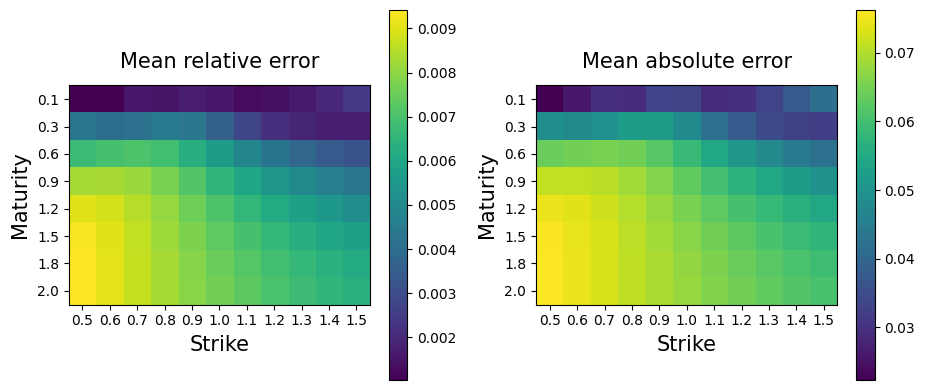

In [24]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

# prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,5))[0].reshape(1, -1)) for i in range(len(y_sample))]
# prediction=scale2.inverse_transform(modelGEN.predict(y_sample))
 
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(np.square((X_sample-prediction)),axis = 0)
plt.title("Mean relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar()

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = np.mean(np.abs((X_sample-prediction)),axis = 0)
plt.title("Mean absolute error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar()

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.tight_layout()
plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Save the Lavenberg-Marquardt Optimal parameters

In [25]:
LMParameters=[Approx[i][3] for i in range(len(Approx))]
np.savetxt("NNParametersHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersHeston.txt")

In [26]:
# Freezing the weights
for layer in modelGEN.layers:
    layer.trainable = False

modelGEN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 40)                240       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dense_3 (Dense)             (None, 88)                3608      
                                                                 
Total params: 7128 (55.69 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7128 (55.69 KB)
_________________________________________________________________


In [27]:
# Ensure using 64-bit floating point numbers
keras.backend.set_floatx('float64')
import keras
from keras.layers import Input, Dense
from keras.models import Model
# Define modelRED
input2 = Input(shape=(88,))
y1 = Dense(30, activation='elu')(input2)
y2 = Dense(30, activation='elu')(y1)
y3 = Dense(30, activation='elu')(y2)
y4 = Dense(5, activation='linear', name="middle")(y3)
y5 = modelGEN(y4)
y6 = tf.keras.layers.concatenate([y4, y5])

modelRED = Model(inputs=input2, outputs=y6)
modelRED.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 88)]                 0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 30)                   2670      ['input_2[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 30)                   930       ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 30)                   930       ['dense_5[0][0]']             
                                                                                            

In [28]:
import keras.backend as K

def create_custom_loss(model):
    def custom_loss(y_true, y_pred):
        # Standard MSE loss
        middle_output = y_pred[:, :5]
        y_pred_loss = y_pred[:, 5:]
        mse = K.mean(K.square(y_pred_loss - y_true), axis=-1)
        
        
        # Additional loss term
        additional_loss = K.relu(K.abs(middle_output) - 1)
        
        # Combine them together
        return mse + K.mean(additional_loss)
    
    return custom_loss
modelRED.compile(optimizer='adam', loss=create_custom_loss(modelRED))



In [29]:
# modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])
modelRED.fit(x_train_transform,x_train_transform, batch_size=32,validation_data = (x_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/200
319/319 [==============================] - 1s 2ms/step - loss: 0.3380 - val_loss: 0.0965
Epoch 2/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0441 - val_loss: 0.0264
Epoch 3/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 4/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 5/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 6/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 7/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 8/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 9/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 10/200
319/319 [==============================] - 1s 2ms/step - loss: 0.0058 - val_lo

KeyboardInterrupt: 

In [30]:
preds = modelRED.predict(x_test_transform, batch_size=1)
preds = preds.reshape(-1,93)
preds = preds[:,:5]
# preds = myinverse(preds[0])

1800/1800 [==============================] - 2s 925us/step


In [31]:
total_error = 0
sample_ind = 0
repriced = []
prediction = []
for i in preds[:5]:
    X_sample = X_test[sample_ind]
    sample_ind += 1
    pricing = price_array(strikes=strikes, maturities=maturities, arr=myinverse(i))
    repriced.append(pricing)
    total_error += np.mean((pricing.reshape(-1)-X_sample)**2)
print(total_error / 1800)
predictions = np.array(repriced)
predictions = predictions.reshape(-1,88)

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')


6.808592524063462e-07


1/1 [==============================] - 0s 24ms/step


c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
C:\Users\takat\AppData\Local\Temp\ipykernel_34236\4199749106.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vols[i,j] = implied_vol(prices[i, j], 1, k, tau, 0, flag='c', q=0, return_as='numpy')


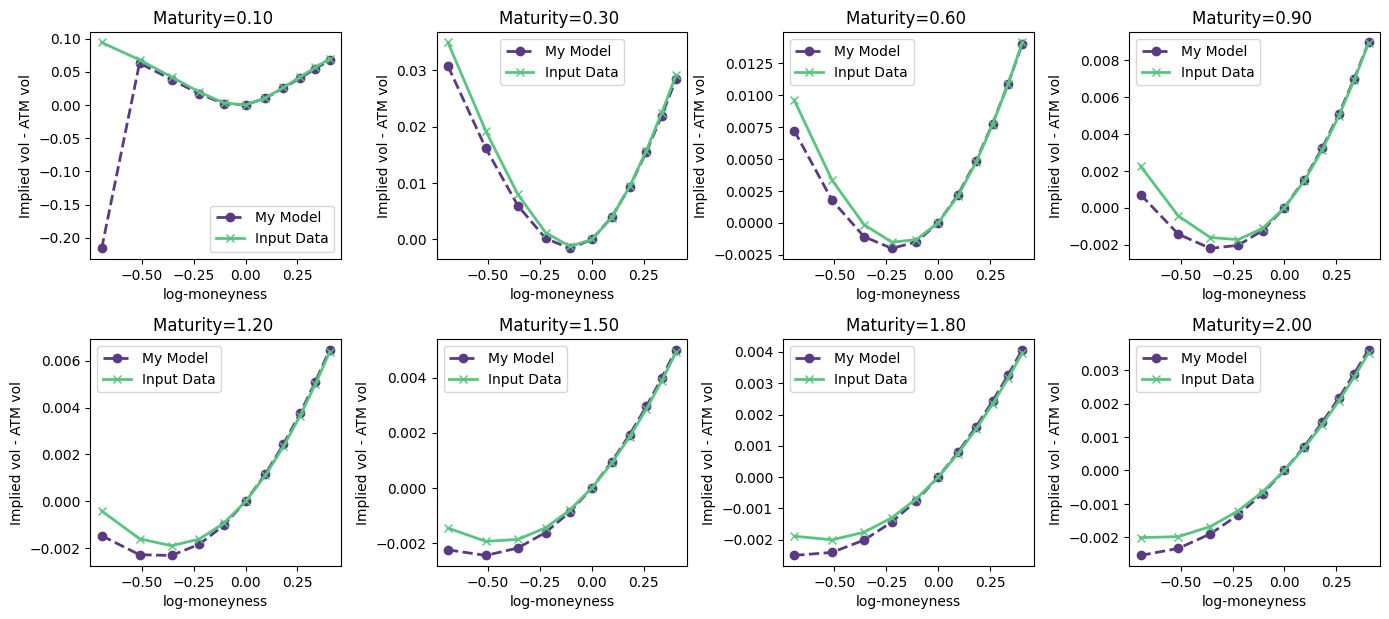

In [56]:
# prediction=xinversetransform(modelGEN.predict(solutions_usefull[0].reshape(1, -1))[0].reshape(1,-1))
sample_ind = 0
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33', '#A65628', '#F781BF', '#999999']
transformed = preds[sample_ind]
prediction = xinversetransform(modelGEN.predict(transformed.reshape(1,5))[0].reshape(1, -1)).reshape(-1)
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
# X_sample = price_array(strikes, maturities, myinverse(y_sample)).reshape(-1)
y_guess = myinverse(transformed)
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)

    reshaped = price_array(strikes, maturities, y_guess).reshape(-1)[i*strikes_dim:(i+1)*strikes_dim]
    # plt.plot(np.log(strikes/S0), 
    #      reshaped - reshaped[5],
    #      color=colors[0], linestyle='--',label="My Model", linewidth=2, marker='o', markersize=6)

    # plt.plot(np.log(strikes/S0), 
    #      X_sample[i*strikes_dim:(i+1)*strikes_dim]-X_sample[i*strikes_dim+5],
    #      color=colors[1], linestyle='-',label="Input Data", linewidth=2, marker='x', markersize=6)
    plt.plot(np.log(strikes/S0), 
         reshaped - reshaped[5],
         color=pastel_color(cm.viridis(0.1)), linestyle='--',label="My Model", linewidth=2, marker='o', markersize=6)

    plt.plot(np.log(strikes/S0), 
         X_sample[i*strikes_dim:(i+1)*strikes_dim]-X_sample[i*strikes_dim+5],
         color=pastel_color(cm.viridis(0.7)), linestyle='-',label="Input Data", linewidth=2, marker='x', markersize=6)

    # plt.plot(np.log(strikes/S0), 
    #      price_array(strikes, maturities, y_guess).reshape(-1)[i*strikes_dim:(i+1)*strikes_dim],
    #      'g--',label="My Model", linewidth=2, marker='o', markersize=6)
    # plt.plot(np.log(strikes/S0), 
    #      X_sample[i*strikes_dim:(i+1)*strikes_dim],
    #      'b',label="Input Data", linewidth=2, marker='x', markersize=6)

#     plt.plot(np.log(strikes/S0), price_array(strikes, maturities, y_guess).reshape(-1)[i*strikes_dim:(i+1)*strikes_dim],'g--',label="mydata")
    # plt.plot(np.log(strikes/S0), X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    # plt.plot(np.log(strikes/S0), prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol - ATM vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

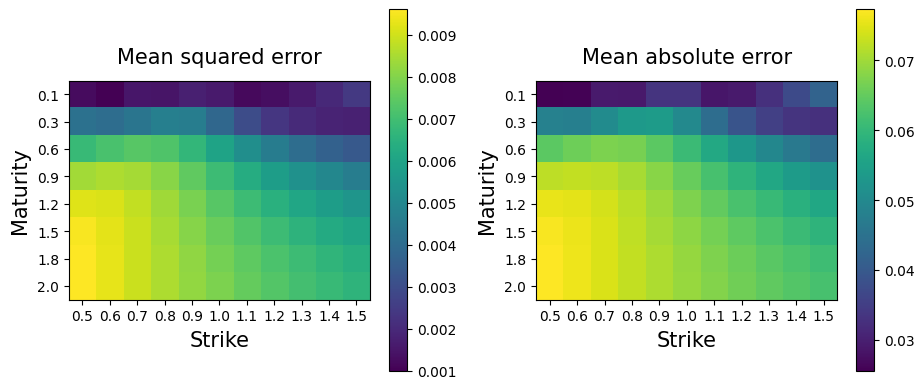

In [33]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

# prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,5))[0].reshape(1, -1)) for i in range(len(y_sample))]
# prediction=scale2.inverse_transform(modelGEN.predict(y_sample))
 
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(np.square((X_sample-prediction)),axis = 0)
plt.title("Mean squared error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar()

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = np.mean(np.abs((X_sample-prediction)),axis = 0)
plt.title("Mean absolute error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar()

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

plt.tight_layout()
plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()

In [ ]:
%timeit modelRED.predict(x_test_transform, batch_size=1800)

1/1 [==============================] - 0s 26ms/step
76.5 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
102/1800*1000

56.666666666666664

In [3]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 10.0                # time in years
r = 0.01               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3.2              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.17**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.028900000000000006, 0.0625)

In [4]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


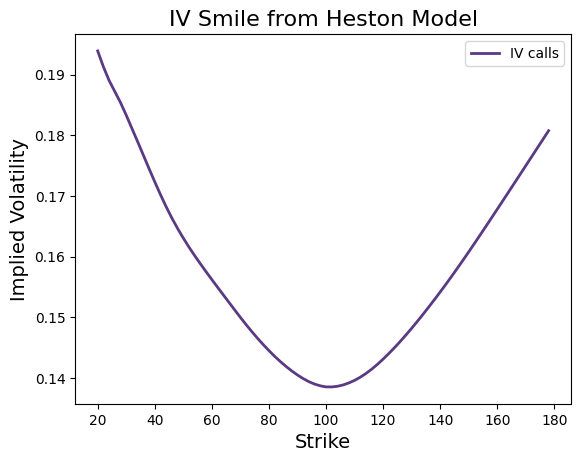

In [5]:
rho = -0.8
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

# plt.plot(K, call_ivs, label=r'IV calls',color=pastel_color(cm.viridis(0.1)))
plt.plot(K, put_ivs, label=r'IV calls', color = pastel_color(cm.viridis(0.1)), linewidth=2)

plt.ylabel('Implied Volatility', fontsize=14)
plt.xlabel('Strike', fontsize=14)

plt.title('IV Smile from Heston Model', fontsize=16)
plt.legend()
plt.show()

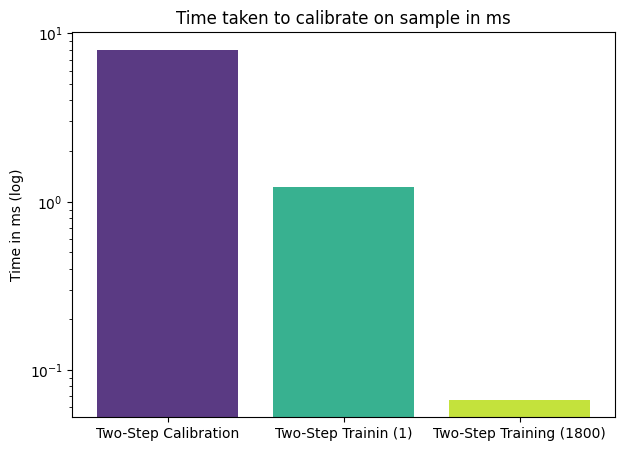

In [7]:

plt.figure(figsize=(7,5))
categories = ['Two-Step Calibration', 'Two-Step Trainin (1)', 'Two-Step Training (1800)']
values = [a, b, c]
# colors = ['red', 'green', 'lightgreen']

colors = ['red', cm.viridis(0.6), cm.viridis(0.9)]
colors = [pastel_color(cm.viridis(0.1)),  # pastel red
          pastel_color(cm.viridis(0.6)),      # pastel viridis shade
          pastel_color(cm.viridis(0.9))]   

plt.bar(categories, values, color=colors)
plt.title('Time taken to calibrate on sample in ms')
plt.yscale('log')
plt.ylabel('Time in ms (log)')

plt.show()


In [20]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=paths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

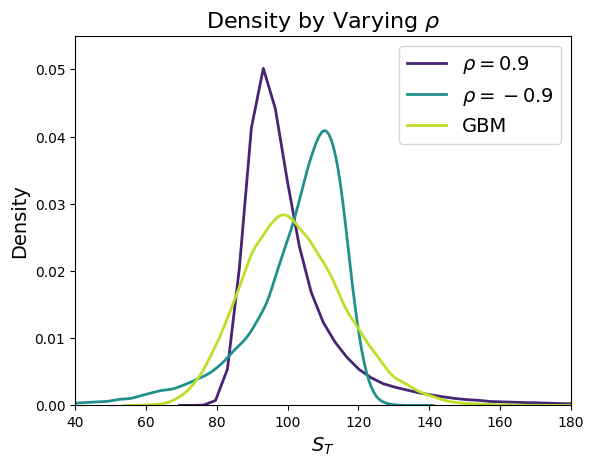

In [27]:
kappa =4
theta = 0.02
v_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =50000
steps = 2000
T = 1

prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]  
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]       
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T , 
                                np.sqrt(theta)*np.sqrt(T), size=paths))

import seaborn as sns

fig, ax = plt.subplots()

# Plot the KDEs with viridis color scheme and increased linewidth
ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax, color=cm.viridis(0.1), linewidth=2)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$", ax=ax, color=cm.viridis(0.5), linewidth=2)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax, color=cm.viridis(0.9), linewidth=2)

# Set the title and axis labels with increased font size
ax.set_title(r'Density by Varying $\rho$', fontsize=16)
ax.set_xlabel('$S_T$', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

# Set the axis limits
ax.axis([40, 180, 0, 0.055])

# Add a legend with increased font size
ax.legend(fontsize=14)

# Show the plot
plt.show()

c:\Users\takat\AppData\Local\Programs\Python\Python311\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


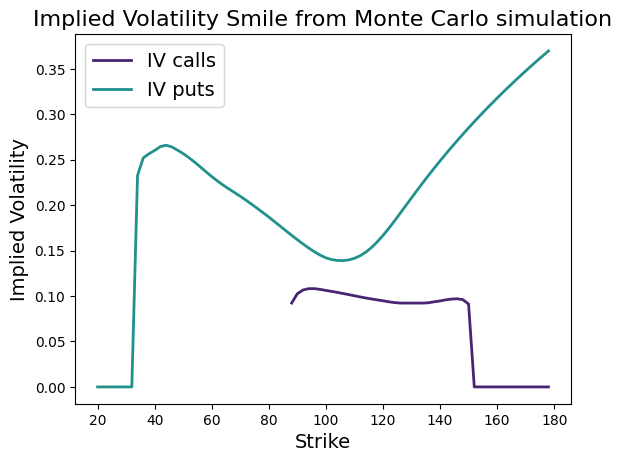

In [26]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)
puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])
put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')
plt.plot(K, call_ivs, label=r'IV calls', color=cm.viridis(0.1), linewidth=2)
plt.plot(K, put_ivs, label=r'IV puts', color=cm.viridis(0.5), linewidth=2)

# Set the title and axis labels with increased font size
plt.title('Implied Volatility Smile from Monte Carlo simulation', fontsize=16)
plt.xlabel('Strike', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)

# Add a legend with increased font size
plt.legend(fontsize=14)

# Show the plot
plt.show()